# **Análise Exploratória de Dados de Logística | André Pereira**

# **1. Resumo**
Esse projeto utiliza uma base de dados da empresa de logística Loggi, os dados são referentes ao Distrito Federal - Brasil, atráves da limpeza e análise desse material buscamos averiguar como está sendo a distribuição dos 3 hubs pela região citada. Levantando algumas questões primordiais.

- A distribuição dos hubs está adequada?
- Quais hubs estão apresentando maior e menor alocação de entregas, verificando possíveis subalocações?
- Qual a porcentagem que cada hub representa perante as entregas totais?
- Quais RAs cada hub atende e quais poderiam ser atendidas?
- Quais RAs tem maior entregas/população, e possíveis motivos para isso.



# **2. Pacotes**

In [1]:
# Instalando e importando todas as bibliotecas utilizadas no projeto
!pip install geopandas

import json
import pandas as pd
import numpy as np
import geopy
import geopandas
import seaborn as sns
import geopy.distance

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

# **3. Dados**
Conforme dito anteriormente, os dados foram cedidos pela empresa  Loggi. Contendo dados de entrega da região do Distrito Federal.

In [2]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [3]:
# Vamos abrir o dado bruto em um dicionário
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

In [4]:
# Agora transformar o dicionário em um Dataframe com Pandas
deliveries_df = pd.DataFrame(data)

In [5]:
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


A coluna "origin" está com um lista dentro, apresentando os valores de longitude e latidude do hub, vamos corrigir para termos cada valor em uma coluna e depois corrigir nos nomes.


In [6]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"]) #divida os dados de origin em duas colunas longitude e latitude
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True) #Junte os dados de origin com os dados originais
deliveries_df = deliveries_df.drop("origin", axis=1) #Retire a coluna Origin anterior
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]] #Corrija a ordem das colunas
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True) #Corrija o nome das colunas lat e lgt para hub_lat e hub_lgt

In [7]:
len(deliveries_df)

199

A coluna "deliveries" apresenta uma questão semelhante, mas aqui os dados não são únicos para cara linha, onde cada linha apresenta todas as entregas realizadas, sendo necessários colocar cada entrega em uma linha.

In [8]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries") #Vamos utilizar o método explode para separar os dados de cada entrega em uma linha no novo dataframe deliveries_exploded_df

#Depois vamos separar cada item do dicionários em uma nova coluna
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)


In [9]:
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


In [10]:
# Agora devemos juntar ao DataFrame original e apargar a coluna anterior
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [11]:
# Ficando assim nosso dataframe corrigido
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


### **4.  Enriquecimento**
Agora vamos trazer algumas melhorias o dado que estamos trabalhando, com a ajuda dos dados de geocodificação da OpenStreetMap e o serviço da Nomitinatim, vamos trazer dados de localização através da Geocodificação Reversa.

**4.1  Endereços das entregas**

Primeiro fazer isso com os dados de localização dos hubs.

In [12]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Queremos saber o endereço de cada um dos hubs e adicioná-los a uma nova coluna

In [13]:
geolocator = Nominatim(user_agent="ebac_geocoder")

In [14]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [15]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Agora vamos separadas cada item do endereço que nos foi fornecido para uma nova coluna, sendo possível ter novas possibilidades na análise.

In [16]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

In [17]:
hub_geodata_df.head(15)

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [18]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]

In [19]:
hub_geodata_df

,address.town,address.suburb,address.city
0,Sobradinho,Sobradinho,NaN
1,NaN,Asa Sul,Brasília
2,NaN,NaN,Taguatinga


Os dados de "town", "suburb" e "city" podem dizer respeito a mesma informação, mas ela está faltante em alguns campos, vamos padronizar e realizar correções para que sempre tenhamos essa informação.

In [20]:
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [21]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)

In [22]:
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]

In [23]:
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


Vamos agora juntar as informações que conseguimos para a nossa Dataframe principal. Aproveitando vamos também organizar a ordem das colunas.

In [24]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


Agora vamos fazer o mesmo procedimento para as entregas, mas aqui encontramos uma limitação técnica, nossa base de dados de geolocalização apresenta uma limitação de uma solicitação por segundo, o que seria impraticável para esse problema, uma vez que são mais de 630 mil entregas.

Vamos então utilizar um servidor local para podermos realizar mais solicitações por segundo.

In [25]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [26]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


E assim vai ficar nossa Dataframe final.

In [27]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Vamos realizar algumas verificações para saber a consistência dos dados.

In [28]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 79.2+ MB


In [29]:
hub_df = deliveries_df.drop(columns=['name', 'hub_city','hub_suburb','vehicle_capacity','delivery_size','delivery_lng','delivery_lat','delivery_city','delivery_suburb'])
hub_df = hub_df.drop_duplicates()
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df = geo_hub_df.reset_index(drop=True)

# **5. Visualizações**


Realizaremos algumas análises referentes as entregas.

In [30]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [31]:
deliveries_df.shape

(636149, 12)

São mais de 600 mil entregas relatadas nesse arquivo.

In [32]:
deliveries_info = deliveries_df[['name','region','delivery_size']].reset_index(drop=True)
deliveries_info.describe()

,delivery_size
count,636149.000000
mean,5.512111
std,2.874557
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,10.000000


Com uma média do tamanho da entrega de 5,51 comum desvio padrão de 2,87.

In [33]:
len(deliveries_df['delivery_city'].drop_duplicates().reset_index(drop=True))

39

Num total de 39 Regiões Administrativas(RA) recebendo entregas.

In [34]:
deliveries_hubs = deliveries_df.value_counts('region')
deliveries_hubs = pd.DataFrame(deliveries_hubs).reset_index()
deliveries_hubs = deliveries_hubs.rename(columns = {0 : 'deliveries'})

Text(0.5, 1.0, 'Entregas por HUB')

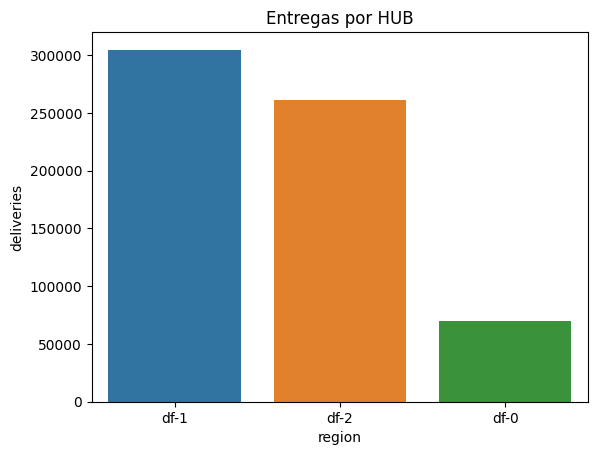

In [35]:
sns.barplot(deliveries_hubs, x = 'region', y = 'deliveries')
plt.title('Entregas por HUB')

O hub df-1 Foi o que mais realizou entregas, enquanto o df-0 o que menos realizou.

Text(0.5, 1.0, 'Participação nas entregas por HUB')

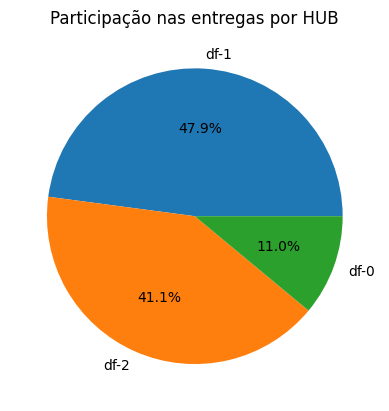

In [36]:
fig, ax = plt.subplots()
ax.pie(deliveries_hubs['deliveries'], labels=deliveries_hubs['region'], autopct='%1.1f%%')
plt.title('Participação nas entregas por HUB')

Onde df-1 representou quase 48% das entregas, enquanto df-0 apenas 11%.

In [37]:
deliveries_df.head()
region_name = deliveries_df[['name', 'region']].drop_duplicates().reset_index(drop = True)
region_name

,name,region
0,cvrp-2-df-33,df-2
1,cvrp-2-df-73,df-2
2,cvrp-2-df-20,df-2
3,cvrp-2-df-87,df-2
4,cvrp-2-df-19,df-2
...,...,...
194,cvrp-0-df-43,df-0
195,cvrp-0-df-85,df-0
196,cvrp-0-df-35,df-0
197,cvrp-0-df-79,df-0


In [38]:
deliveries_sizes = deliveries_df.groupby('name')['delivery_size'].sum().reset_index()
deliveries_sizes = pd.merge(left = deliveries_sizes, right = region_name, on = 'name')
deliveries_sizes

,name,delivery_size,region
0,cvrp-0-df-1,5680,df-0
1,cvrp-0-df-10,5533,df-0
2,cvrp-0-df-11,4993,df-0
3,cvrp-0-df-12,4440,df-0
4,cvrp-0-df-13,5612,df-0
...,...,...,...
194,cvrp-2-df-81,24288,df-2
195,cvrp-2-df-82,26604,df-2
196,cvrp-2-df-84,20225,df-2
197,cvrp-2-df-87,28366,df-2


<ipython-input-39-80121e5704db>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  deliveries_sizes.groupby('region').mean()


Text(0.5, 1.0, 'Média de Viagens')

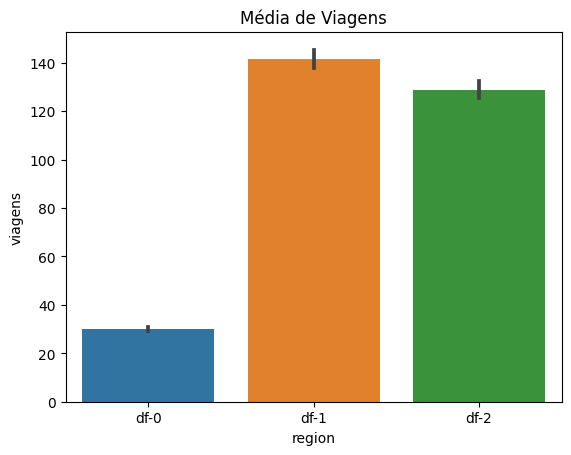

In [39]:
deliveries_sizes['viagens'] = deliveries_sizes['delivery_size'] / 180
deliveries_sizes.groupby('region').mean()
sns.barplot(deliveries_sizes, x = "region", y= "viagens")
plt.title('Média de Viagens')

Foi também o df-1 que mais realizou viagens.

Agora vamos realizar análises com os mapas.
Para isso vamos usar o dados de Geolocalização e Demográficos do Geoportal do Distrito Federal.

In [40]:
#Fonte: https://www.geoportal.seduh.df.gov.br/
!wget -q "https://github.com/andrepeersil/ebac-analisededados-proj01/raw/main/regioes_administrativas.dbf"
!wget -q "https://github.com/andrepeersil/ebac-analisededados-proj01/raw/main/regioes_administrativas.prj"
!wget -q "https://github.com/andrepeersil/ebac-analisededados-proj01/raw/main/regioes_administrativas.shp"
!wget -q "https://github.com/andrepeersil/ebac-analisededados-proj01/raw/main/regioes_administrativas.shx"

In [41]:
df_mapDF = geopandas.read_file("regioes_administrativas.shp",encoding='utf-8')
df_mapDF.head()

,ra_cira,ra_nome,ra_codigo,ra_path,st_area_sh,st_length_,geometry
0,1,PLANO PILOTO,RA-I,https://www.geoservicos1.segeth.df.gov.br/anex...,4.372014e+08,184204.574473,"POLYGON ((193478.148 8263481.141, 193477.162 8..."
1,2,GAMA,RA-II,https://www.geoservicos1.segeth.df.gov.br/anex...,2.754143e+08,88879.970482,"POLYGON ((168705.252 8236087.450, 168711.503 8..."
2,4,BRAZLÂNDIA,RA-IV,https://www.geoservicos1.segeth.df.gov.br/anex...,4.701836e+08,107050.466657,"POLYGON ((174420.081 8280562.021, 174439.604 8..."
3,5,SOBRADINHO,RA-V,https://www.geoservicos1.segeth.df.gov.br/anex...,1.935265e+08,102972.805688,"POLYGON ((203513.962 8281431.436, 203513.986 8..."
4,9,CEILÂNDIA,RA-IX,https://www.geoservicos1.segeth.df.gov.br/anex...,1.926569e+08,117499.507891,"POLYGON ((159451.527 8256079.011, 159529.189 8..."


Vamos utilizar apenas as informações do nome da Região Administração e do mapa.

As informações de Geometria estão em UTM e precisa estar em Longitude e Latitude, que é o formato das entregas.

<Axes: >

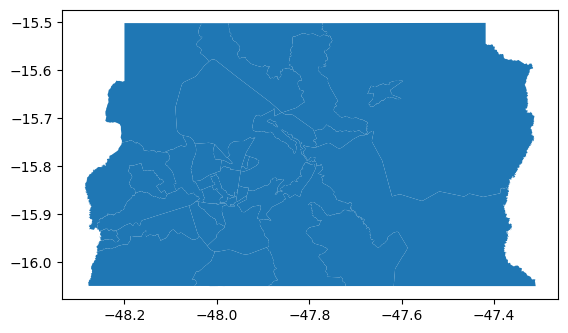

In [42]:
df_mapDF = df_mapDF[["ra_nome","geometry"]]
df_mapDF = df_mapDF.to_crs("EPSG:4326")
df_mapDF.plot()

Vamos utlizar os dados de população, também sendo fonte Geo Portal Distrito Federal

In [43]:
!wget -q "https://raw.githubusercontent.com/andrepeersil/ebac-analisededados-proj01/main/pop.csv"

In [44]:
df_pop = pd.read_csv('pop.csv', sep=';',encoding='utf-8')
df_pop = df_pop.rename(columns={'Região Administrativa' : 'ra_nome',  'População Total' : 'pop_total' })
df_pop["ra_nome"] = df_pop["ra_nome"].apply(lambda nome: nome.strip())
df_pop.head()

,ra_nome,pop_total
0,CRUZEIRO,31514
1,SOBRADINHO II,80830
2,CANDANGOLÂNDIA,16019
3,BRAZLÂNDIA,57974
4,SAMAMBAIA,201230


Precisamos agora criar um novo Data Frame com as duas informações, do mapa e de população.

Vamos aproveitar para gerar um mapa com as informações de população.

In [45]:
df_infos = pd.merge(df_pop, df_mapDF, how="outer", on = "ra_nome")
df_map = geopandas.GeoDataFrame(df_infos)

df_map.head()

,ra_nome,pop_total,geometry
0,CRUZEIRO,31514,"POLYGON ((-47.93818 -15.80552, -47.93963 -15.8..."
1,SOBRADINHO II,80830,"POLYGON ((-47.96747 -15.53149, -47.96723 -15.5..."
2,CANDANGOLÂNDIA,16019,"POLYGON ((-47.93232 -15.85129, -47.93238 -15.8..."
3,BRAZLÂNDIA,57974,"POLYGON ((-48.03485 -15.53163, -48.03466 -15.5..."
4,SAMAMBAIA,201230,"POLYGON ((-48.07511 -15.84615, -48.07483 -15.8..."


Queremos agora a contagem de entregas por RA.

Para seguir o padrão, vamos deixar as letras maiúsculas, se seguir o mesmo padrão de nomes das colunas.

In [47]:
deliveries_df_count = deliveries_df.value_counts("delivery_city")
deliveries_df_count = pd.DataFrame(deliveries_df_count).reset_index()
deliveries_df_count = deliveries_df_count.rename(columns = {"delivery_city":"ra_nome",0:"deliveries"})
deliveries_df_count["ra_nome"] = deliveries_df_count["ra_nome"].str.upper()
deliveries_df_count.head()

,ra_nome,deliveries
0,BRASÍLIA,148983
1,TAGUATINGA,45564
2,SUDOESTE / OCTOGONAL,44215
3,CEILÂNDIA,37953
4,ÁGUAS CLARAS,37083


Podemos ver a maior parte das entregas é da cidade de Brasília.


Vamos também agregar RAs com poucas entregas, para melhoras nossa visualização.

In [48]:
deliveries_df_count_filter = deliveries_df_count[deliveries_df_count['deliveries'] >= 5000]
deliveries_df_count_other = deliveries_df_count[deliveries_df_count['deliveries'] <= 5000]
deliveries_count_sum = deliveries_df_count_other['deliveries'].sum()
deliveries_df_count_sum = pd.DataFrame([{'ra_nome' : 'Outros', 'deliveries' :  deliveries_count_sum}])
deliveries_df_count_sum

,ra_nome,deliveries
0,Outros,15631


In [49]:
deliveries_df_count_merge = pd.concat([deliveries_df_count_filter, deliveries_df_count_sum], axis=0).reset_index(drop = True)
deliveries_df_count_merge

,ra_nome,deliveries
0,BRASÍLIA,148983
1,TAGUATINGA,45564
2,SUDOESTE / OCTOGONAL,44215
3,CEILÂNDIA,37953
4,ÁGUAS CLARAS,37083
5,GUARÁ,35382
6,LAGO SUL,29021
7,SOBRADINHO,28889
8,LAGO NORTE,25975
9,GAMA,22189


Text(0.5, 1.0, 'Participação nas entregas por Cidade')

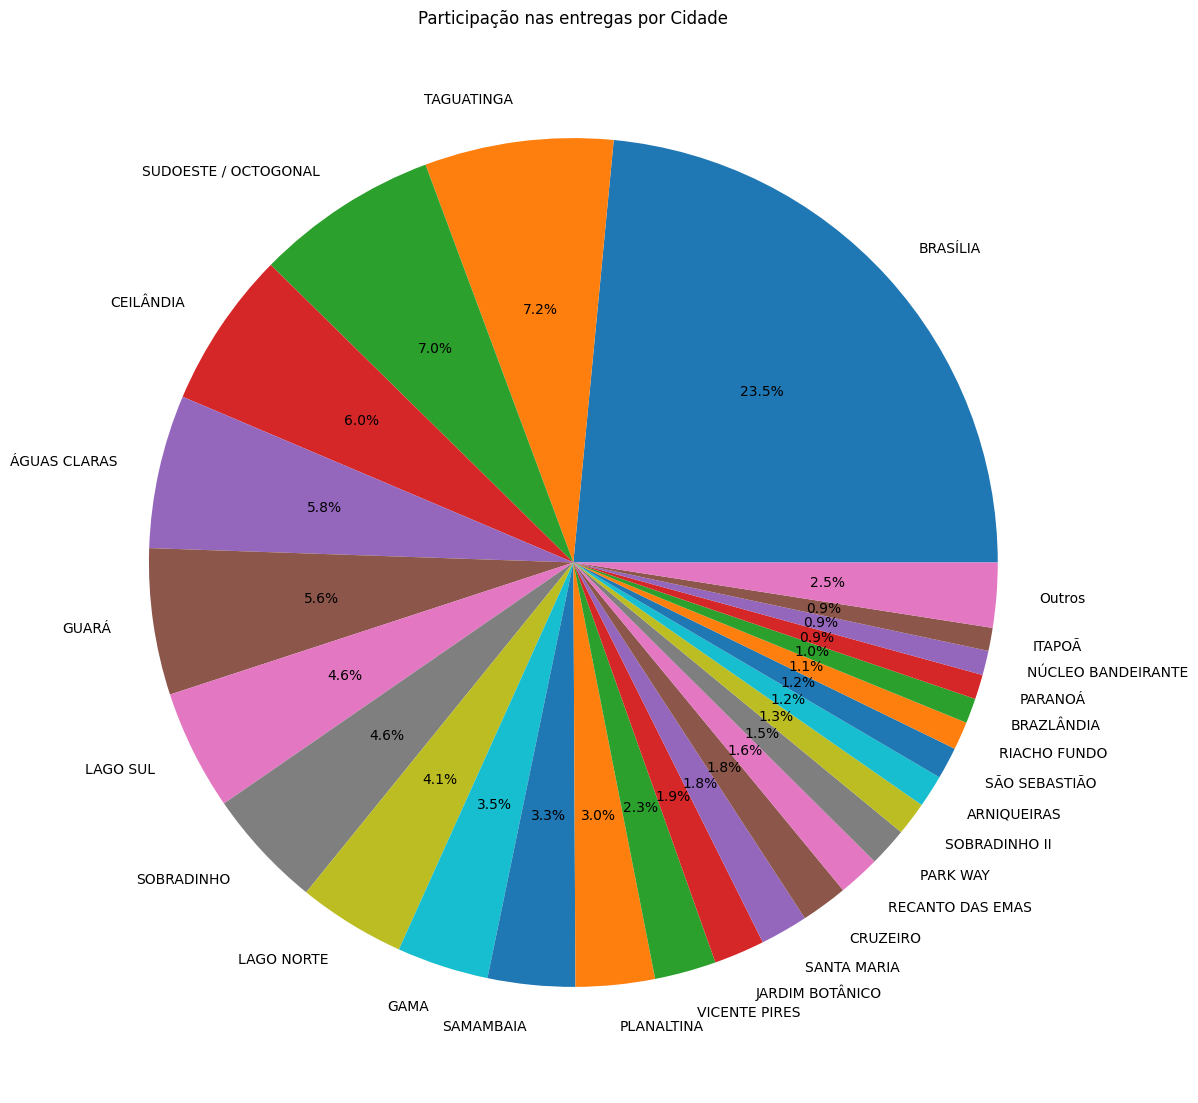

In [50]:
fig, ax = plt.subplots(figsize = (35/2.54, 35/2.54))

ax.pie(deliveries_df_count_merge['deliveries'], labels = deliveries_df_count_merge['ra_nome'], autopct='%1.1f%%')
plt.title('Participação nas entregas por Cidade')

A cidade de Brasília atende por 23,5% das entregas realizadas.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'BRASÍLIA'),
  Text(1, 0, 'TAGUATINGA'),
  Text(2, 0, 'SUDOESTE / OCTOGONAL'),
  Text(3, 0, 'CEILÂNDIA'),
  Text(4, 0, 'ÁGUAS CLARAS'),
  Text(5, 0, 'GUARÁ'),
  Text(6, 0, 'LAGO SUL'),
  Text(7, 0, 'SOBRADINHO'),
  Text(8, 0, 'LAGO NORTE'),
  Text(9, 0, 'GAMA'),
  Text(10, 0, 'SAMAMBAIA'),
  Text(11, 0, 'PLANALTINA'),
  Text(12, 0, 'VICENTE PIRES'),
  Text(13, 0, 'JARDIM BOTÂNICO'),
  Text(14, 0, 'SANTA MARIA'),
  Text(15, 0, 'CRUZEIRO'),
  Text(16, 0, 'RECANTO DAS EMAS'),
  Text(17, 0, 'PARK WAY'),
  Text(18, 0, 'SOBRADINHO II'),
  Text(19, 0, 'ARNIQUEIRAS'),
  Text(20, 0, 'SÃO SEBASTIÃO'),
  Text(21, 0, 'RIACHO FUNDO'),
  Text(22, 0, 'BRAZLÂNDIA'),
  Text(23, 0, 'PARANOÁ'),
  Text(24, 0, 'NÚCLEO BANDEIRANTE'),
  Text(25, 0, 'ITAPOÃ'),
  Text(26, 0, 'Outros')])

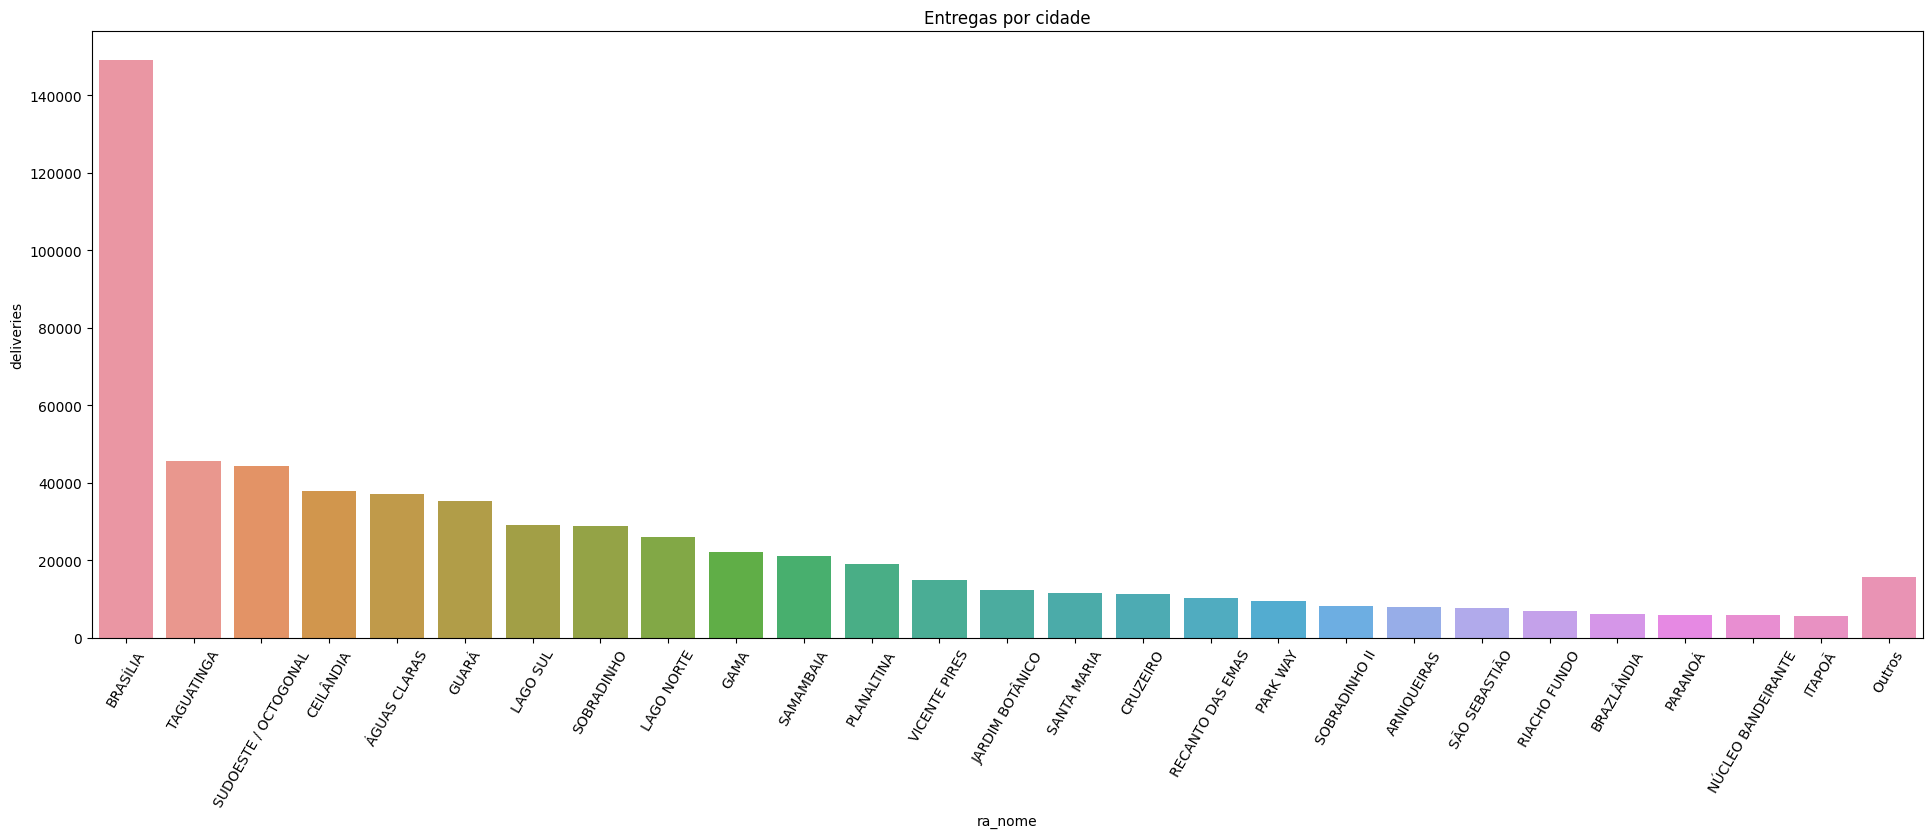

In [51]:
fig, ax = plt.subplots(figsize = (60/2.54, 20/2.54))

sns.barplot(deliveries_df_count_merge, x = "ra_nome", y= "deliveries")
plt.title('Entregas por cidade')
plt.xticks(rotation=60)

In [52]:
geo_deliveries_map_df = pd.merge(left=df_infos, right = deliveries_df_count, on = 'ra_nome', how = "outer")
geo_deliveries_map_df.sort_values("ra_nome", ascending= True)
geo_deliveries_map_df.head()

,ra_nome,pop_total,geometry,deliveries
0,CRUZEIRO,31514.0,"POLYGON ((-47.93818 -15.80552, -47.93963 -15.8...",11296.0
1,SOBRADINHO II,80830.0,"POLYGON ((-47.96747 -15.53149, -47.96723 -15.5...",8111.0
2,CANDANGOLÂNDIA,16019.0,"POLYGON ((-47.93232 -15.85129, -47.93238 -15.8...",2943.0
3,BRAZLÂNDIA,57974.0,"POLYGON ((-48.03485 -15.53163, -48.03466 -15.5...",6043.0
4,SAMAMBAIA,201230.0,"POLYGON ((-48.07511 -15.84615, -48.07483 -15.8...",21081.0


In [53]:
geo_deliveries_map_df = geopandas.GeoDataFrame(geo_deliveries_map_df)

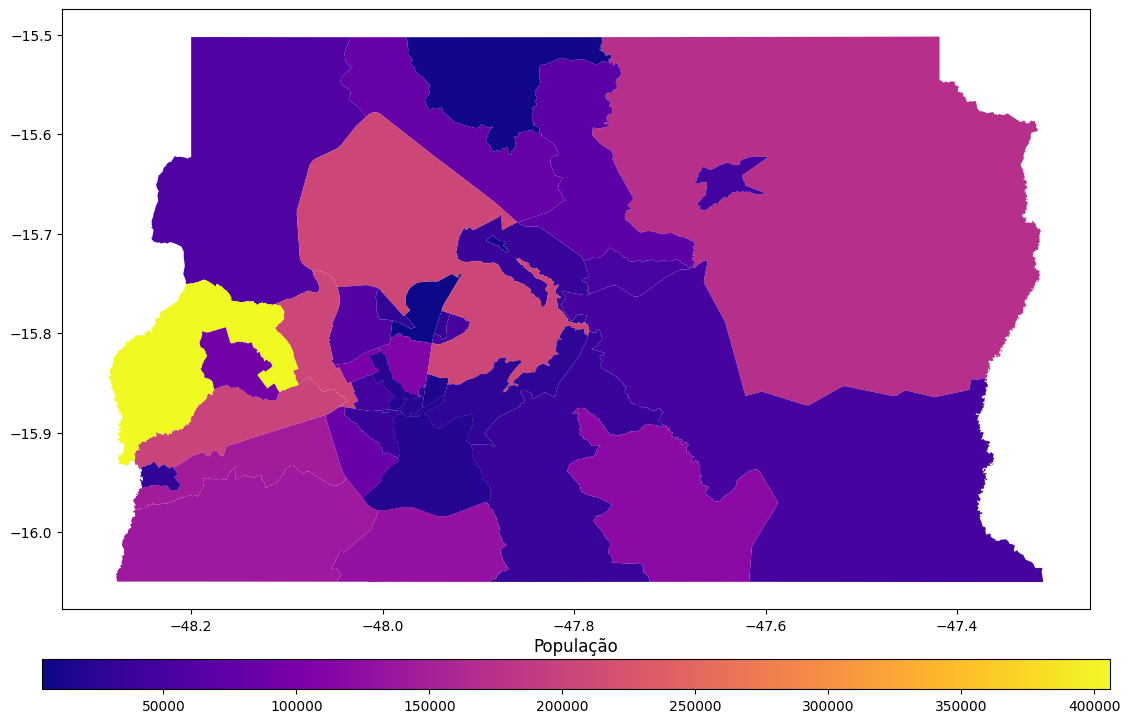

In [54]:
fig, ax = plt.subplots(figsize = (35/2.54, 35/2.54))

norm = colors.Normalize(geo_deliveries_map_df["pop_total"].min(), geo_deliveries_map_df["pop_total"].max())

cmap = plt.cm.plasma
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)

geo_deliveries_map_df.plot(ax=ax, cmap='plasma', column='pop_total')

plt.title("População")
plt.show()


As RAs não estão padronizadas, vamos retirar os nomes que não estão alinhas, pois eles aparecem no mapa, mas com outros nomes, por exemplo, Brasília foi marcada em diversas entregas, mas não é considerada uma RA.

In [55]:
geo_deliveries_map_df[geo_deliveries_map_df["geometry"] == None]

,ra_nome,pop_total,geometry,deliveries
36,BRASÍLIA,NaN,None,148983.0
37,SUDOESTE / OCTOGONAL,NaN,None,44215.0
38,ARNIQUEIRAS,NaN,None,7823.0
39,SOL NASCENTE/PÔR DO SOL,NaN,None,4408.0
40,AGROVILA CAFÉ SEM TROCO,NaN,None,37.0
41,CAFÉ SEM TROCO,NaN,None,12.0
42,VALPARAÍSO DE GOIÁS,NaN,None,7.0
43,ÁGUAS LINDAS DE GOIÁS,NaN,None,2.0
44,SANTO ANTÔNIO DO DESCOBERTO,NaN,None,1.0
45,NOVO GAMA,NaN,None,1.0


O inverso também ocorre, onde RAs que não tiveram nenhuma entrega registrada.

In [56]:
geo_deliveries_map_df[geo_deliveries_map_df["deliveries"].isna()]

,ra_nome,pop_total,geometry,deliveries
5,SUDOESTE/OCTOGONAL,50033.0,"POLYGON ((-47.92920 -15.78017, -47.92907 -15.7...",NaN
9,VARJÃO,8793.0,"POLYGON ((-47.86810 -15.71646, -47.86968 -15.7...",NaN
22,FERCAL,8763.0,"POLYGON ((-47.77180 -15.50276, -47.77174 -15.5...",NaN
31,ARAPOANGA,47336.0,"POLYGON ((-47.60056 -15.62230, -47.60051 -15.6...",NaN
33,SOL NASCENTE E POR DO SOL,92217.0,"POLYGON ((-48.16360 -15.79501, -48.15915 -15.8...",NaN
34,ARNIQUEIRA,46621.0,"POLYGON ((-48.00957 -15.84399, -48.00915 -15.8...",NaN
35,AGUA QUENTE,30000.0,"POLYGON ((-48.23863 -15.92920, -48.23860 -15.9...",NaN


In [57]:
geo_deliveries_map_df = geopandas.GeoDataFrame(geo_deliveries_map_df)

In [58]:
geo_deliveries_map_df = geo_deliveries_map_df.dropna(subset = ["pop_total"])
geo_deliveries_map_df["deliveries"] = geo_deliveries_map_df["deliveries"].fillna(0)
geo_deliveries_map_df["deliveries/pop"] = geo_deliveries_map_df["deliveries"] / geo_deliveries_map_df["pop_total"]
geo_deliveries_map_df.head()

,ra_nome,pop_total,geometry,deliveries,deliveries/pop
0,CRUZEIRO,31514.0,"POLYGON ((-47.93818 -15.80552, -47.93963 -15.8...",11296.0,0.358444
1,SOBRADINHO II,80830.0,"POLYGON ((-47.96747 -15.53149, -47.96723 -15.5...",8111.0,0.100346
2,CANDANGOLÂNDIA,16019.0,"POLYGON ((-47.93232 -15.85129, -47.93238 -15.8...",2943.0,0.183719
3,BRAZLÂNDIA,57974.0,"POLYGON ((-48.03485 -15.53163, -48.03466 -15.5...",6043.0,0.104236
4,SAMAMBAIA,201230.0,"POLYGON ((-48.07511 -15.84615, -48.07483 -15.8...",21081.0,0.104761


Criação da coluna de Área, para isso temos que transformas os dados de localixação em UTM, para ter o valor correto.

In [59]:
geo_deliveries_map_df.crs = "EPSG:4326"
gdf_utm = geo_deliveries_map_df.to_crs(epsg=32723)
gdf_utm['area'] = gdf_utm.geometry.area

geo_deliveries_map_df["area(km²)"] = gdf_utm["geometry"].area/ 1e6 # O dados sai em m², essa divisão nos dá em km²
geo_deliveries_map_df.head()

,ra_nome,pop_total,geometry,deliveries,deliveries/pop,area(km²)
0,CRUZEIRO,31514.0,"POLYGON ((-47.93818 -15.80552, -47.93963 -15.8...",11296.0,0.358444,3.191164
1,SOBRADINHO II,80830.0,"POLYGON ((-47.96747 -15.53149, -47.96723 -15.5...",8111.0,0.100346,181.352094
2,CANDANGOLÂNDIA,16019.0,"POLYGON ((-47.93232 -15.85129, -47.93238 -15.8...",2943.0,0.183719,6.601864
3,BRAZLÂNDIA,57974.0,"POLYGON ((-48.03485 -15.53163, -48.03466 -15.5...",6043.0,0.104236,470.183559
4,SAMAMBAIA,201230.0,"POLYGON ((-48.07511 -15.84615, -48.07483 -15.8...",21081.0,0.104761,99.992287


Verificando a unidade de medida do mapa de UTM.

In [61]:
print(gdf_utm.crs.axis_info[0].unit_name)

metre


Criação da coluna de Densidade Populacional

In [62]:
geo_deliveries_map_df["dens. pop"] = geo_deliveries_map_df["pop_total"] / geo_deliveries_map_df["area(km²)"]
geo_deliveries_map_df.head()

,ra_nome,pop_total,geometry,deliveries,deliveries/pop,area(km²),dens. pop
0,CRUZEIRO,31514.0,"POLYGON ((-47.93818 -15.80552, -47.93963 -15.8...",11296.0,0.358444,3.191164,9875.394796
1,SOBRADINHO II,80830.0,"POLYGON ((-47.96747 -15.53149, -47.96723 -15.5...",8111.0,0.100346,181.352094,445.707565
2,CANDANGOLÂNDIA,16019.0,"POLYGON ((-47.93232 -15.85129, -47.93238 -15.8...",2943.0,0.183719,6.601864,2426.435779
3,BRAZLÂNDIA,57974.0,"POLYGON ((-48.03485 -15.53163, -48.03466 -15.5...",6043.0,0.104236,470.183559,123.300781
4,SAMAMBAIA,201230.0,"POLYGON ((-48.07511 -15.84615, -48.07483 -15.8...",21081.0,0.104761,99.992287,2012.455226


Criando o mapa de densidade populacional.

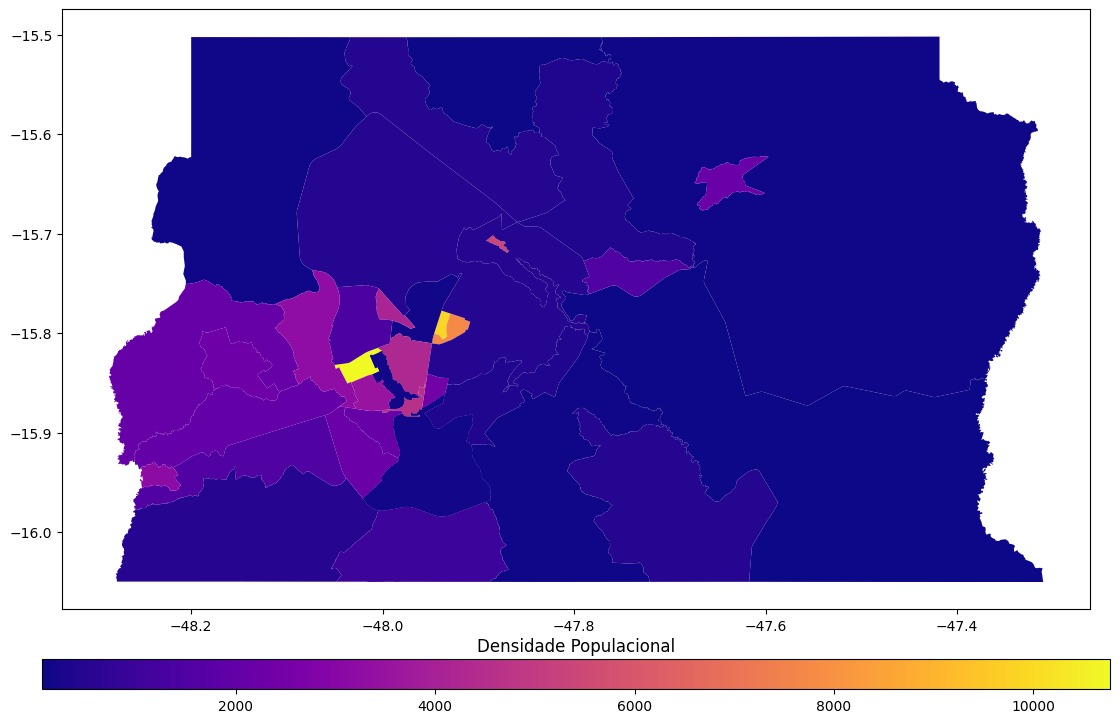

In [63]:
fig, ax = plt.subplots(figsize = (35/2.54, 35/2.54))

norm = colors.Normalize(geo_deliveries_map_df["dens. pop"].min(), geo_deliveries_map_df["dens. pop"].max())

cmap = plt.cm.plasma
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)

geo_deliveries_map_df.plot(ax=ax, cmap='plasma', column='dens. pop')

plt.title("Densidade Populacional")
plt.show()


A região Centro-Oeste apresenta maior Densidade Populacional.

Analiasando a taxa de Entregas sobre a População da RA.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 [Text(0, 0, 'CRUZEIRO'),
  Text(1, 0, 'SOBRADINHO II'),
  Text(2, 0, 'CANDANGOLÂNDIA'),
  Text(3, 0, 'BRAZLÂNDIA'),
  Text(4, 0, 'SAMAMBAIA'),
  Text(5, 0, 'SUDOESTE/OCTOGONAL'),
  Text(6, 0, 'SIA'),
  Text(7, 0, 'PLANALTINA'),
  Text(8, 0, 'PARANOÁ'),
  Text(9, 0, 'VARJÃO'),
  Text(10, 0, 'GUARÁ'),
  Text(11, 0, 'CEILÂNDIA'),
  Text(12, 0, 'PARK WAY'),
  Text(13, 0, 'ÁGUAS CLARAS'),
  Text(14, 0, 'LAGO NORTE'),
  Text(15, 0, 'PLANO PILOTO'),
  Text(16, 0, 'JARDIM BOTÂNICO'),
  Text(17, 0, 'SOBRADINHO'),
  Text(18, 0, 'NÚCLEO BANDEIRANTE'),
  Text(19, 0, 'SCIA'),
  Text(20, 0, 'LAGO SUL'),
  Text(21, 0, 'FERCAL'),
  Text(22, 0, 'VICENTE PIRES'),
  Text(23, 0, 'ITAPOÃ'),
  Text(24, 0, 'TAGUATINGA'),
  Text(25, 0, 'GAMA'),
  Text(26, 0, 'RIACHO FUNDO'),
  Text(27, 0, 'RIACHO FUNDO II'),
  Text(28, 0, 'SANTA MARIA'),
  Text(

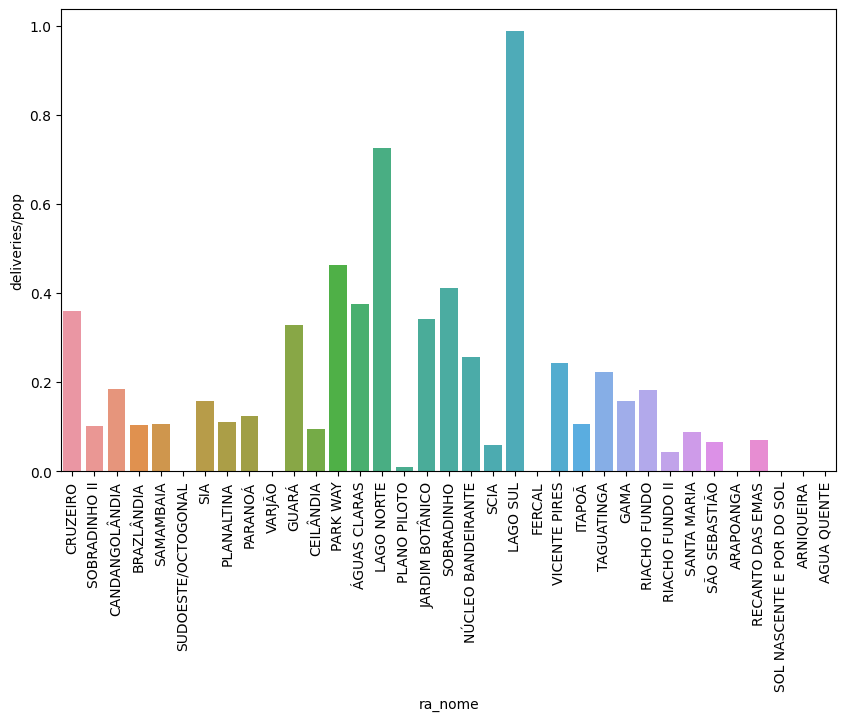

In [64]:
plt.figure(figsize=(10, 6))
graf = sns.barplot(x=geo_deliveries_map_df["ra_nome"],y=geo_deliveries_map_df["deliveries/pop"])
plt.xticks(rotation=90)

<ipython-input-67-0f8894b7d8c2>:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


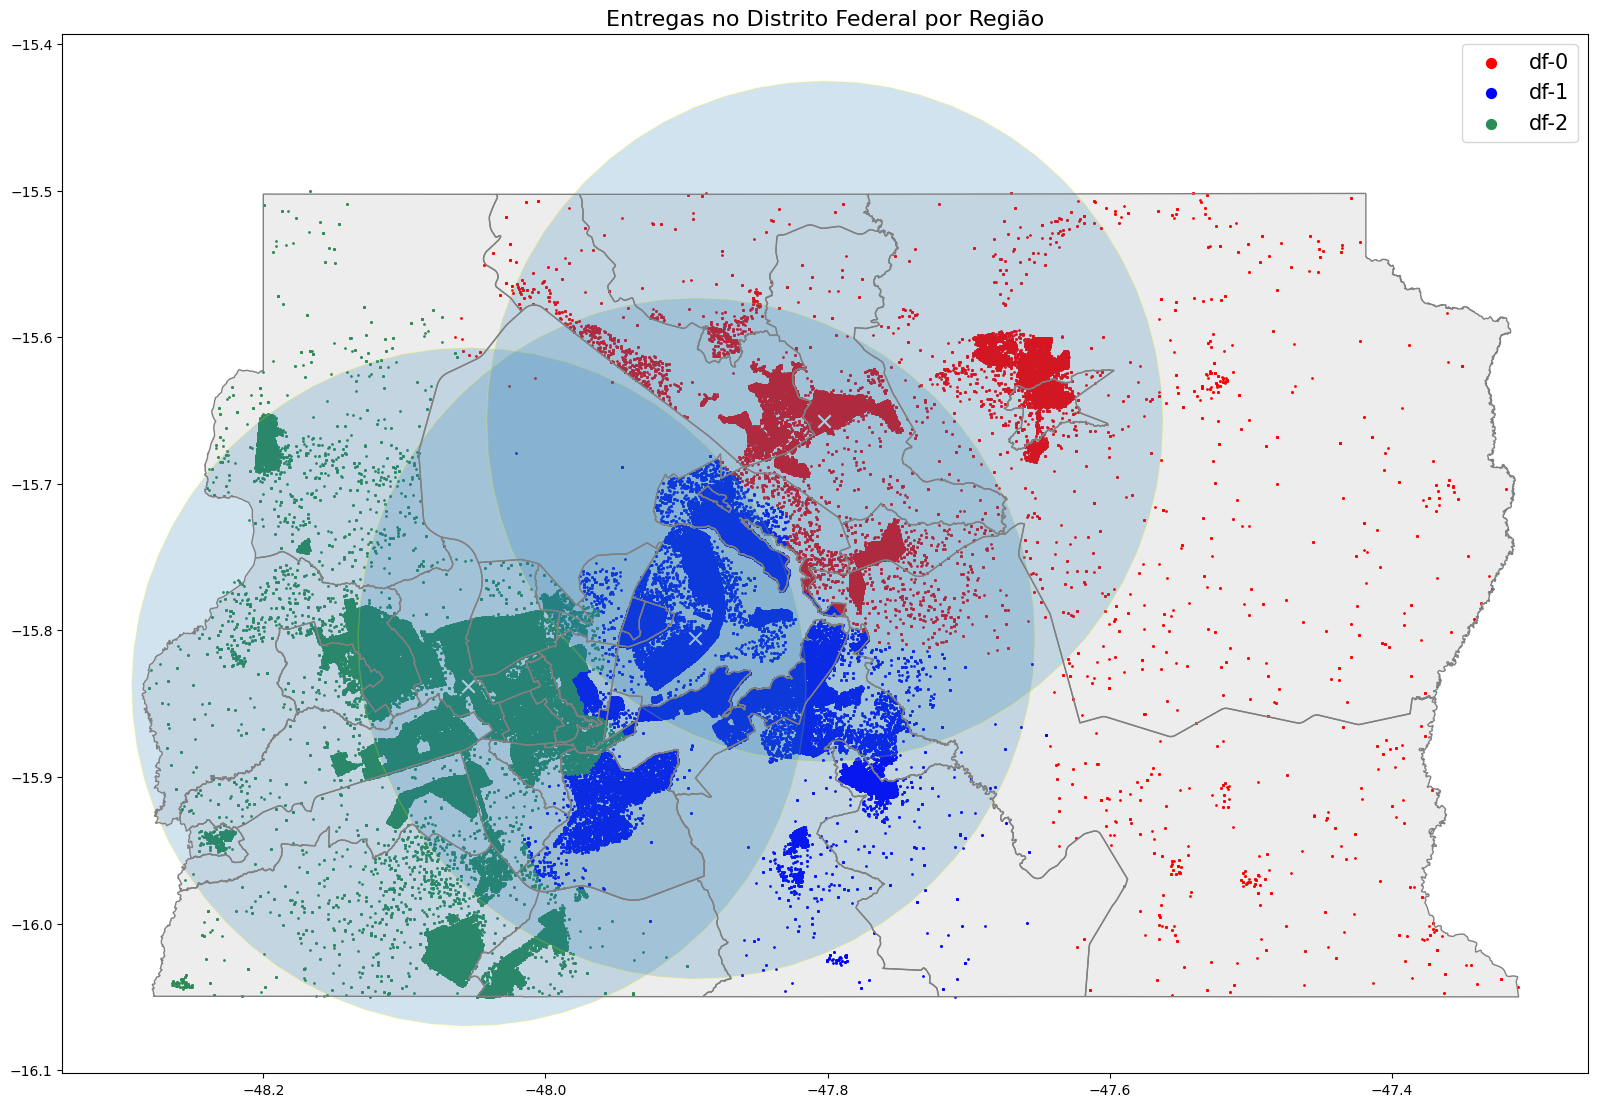

In [67]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
df_map.plot(ax=ax, alpha=0.4, color="lightgrey")
df_map.boundary.plot(ax=ax, color="gray", linewidth=1)

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")


# plot dos hubs
geo_hub_df.plot(ax=ax, marker='x', color='white', markersize=80)

gdf = geopandas.GeoDataFrame(geo_hub_df)
gdf.set_geometry('geometry', inplace=True)
gdf.crs = "EPSG:4326"
gdf_utm = gdf.to_crs(epsg=32633)
gdf_utm['geometry'] = gdf_utm.geometry.buffer(50000)
gdf_buffer = gdf_utm.to_crs(epsg=4326)
gdf_buffer.plot(ax=ax, edgecolor='yellow', alpha=0.2)

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

plt.show()

Lago Sul se destaca com uma alta taxa de Entregas em relação a sua População

Vamos agora plotar no mapa as entregas para novas análises.

In [65]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [66]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


Criação do Gráfico da Distribuição das Entregas, assim como a localização de seus HUBs.

A Distribuição dos HUBs está próximo do ótimo, o raio ajuda a visualizar áreas que cada HUB pode suprir.

Vemos anteriormente que df-0 tem poucas entregas, o que também fica claro no mapa. Podendo ser alocado mais ao Sul e ao Oeste. Realizando as entregas do df-1.

Assim também seria possível pensar um cenários de df-1 e df2 tivessem menos entregas. Onde df-2 abrange uma área bastante extensa, que poderia ser redivida.

Enquanto df-1, apesar de ter o maior número de entregas, elas são menos espalhadas, se concentrando quase por completo dentro do círculo de 10km de raio.

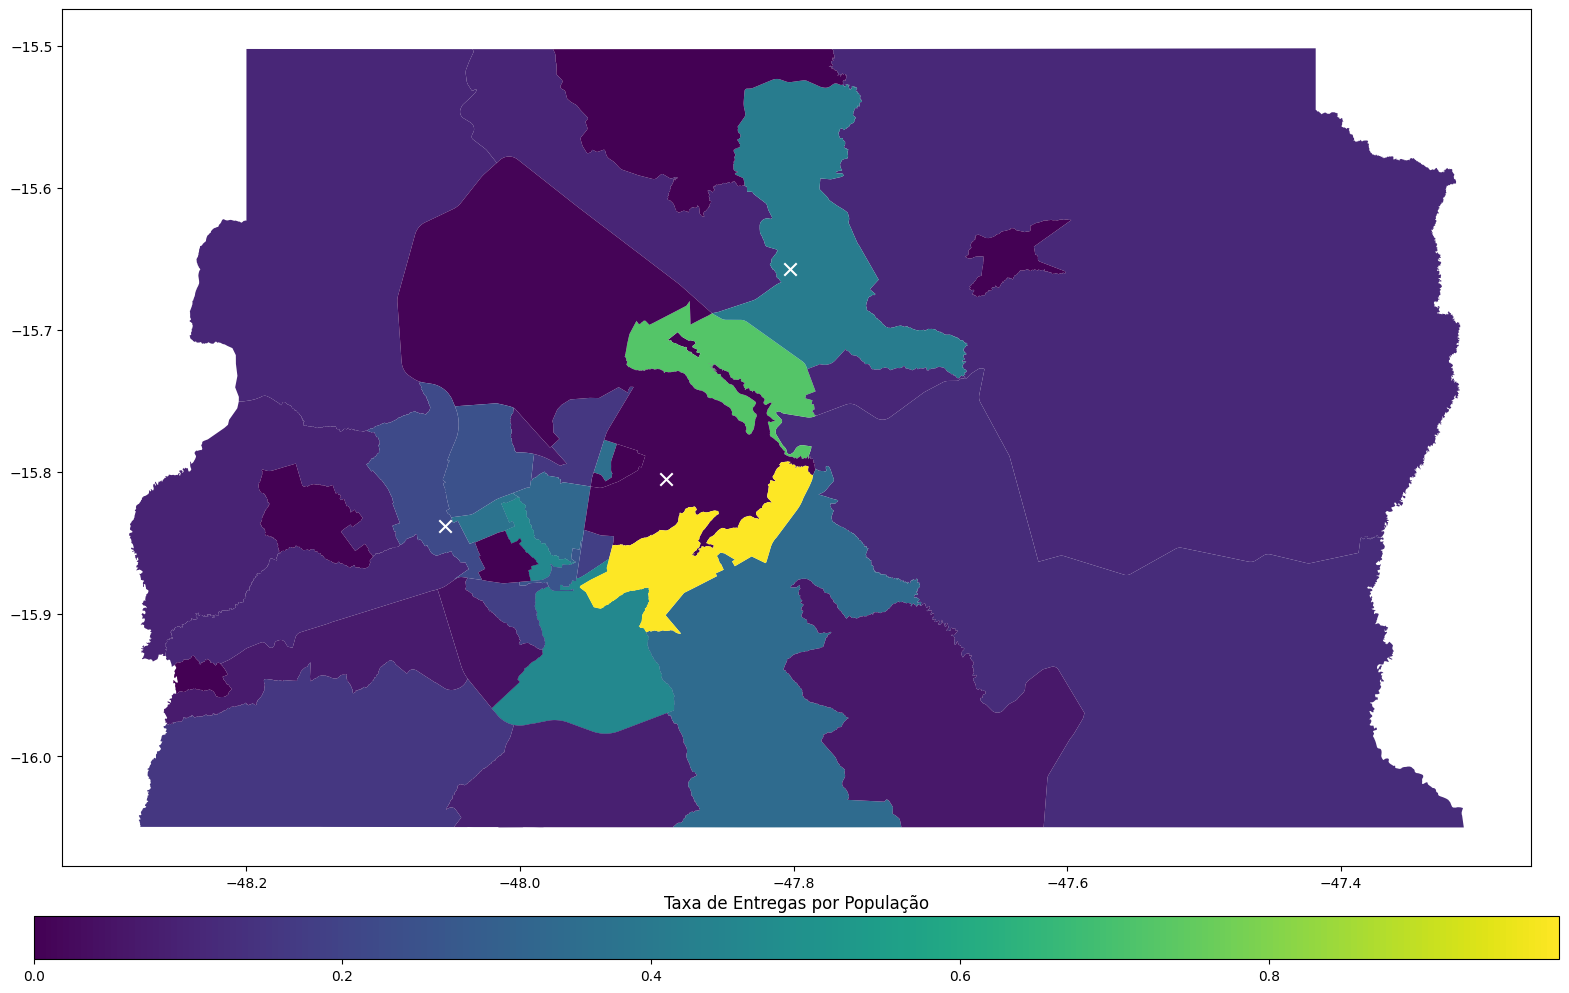

In [68]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Iterar sobre cada linha no GeoDataFrame
for idx, row in geo_deliveries_map_df.iterrows():
    if row['geometry'].geom_type == 'Point':
        x, y = row['geometry'].x, row['geometry'].y
    else:
        x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
# plot mapa do distrito federal
geo_deliveries_map_df.plot(ax=ax, column = 'deliveries/pop')

norm = colors.Normalize(geo_deliveries_map_df["deliveries/pop"].min(), geo_deliveries_map_df["deliveries/pop"].max())

cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)

# plot dos hubs
geo_hub_df.plot(ax=ax, marker='x', color='white', markersize=80)

plt.title("Taxa de Entregas por População")
plt.show()


POr último vamos plotar um gráfico de Entregas totais por RA.

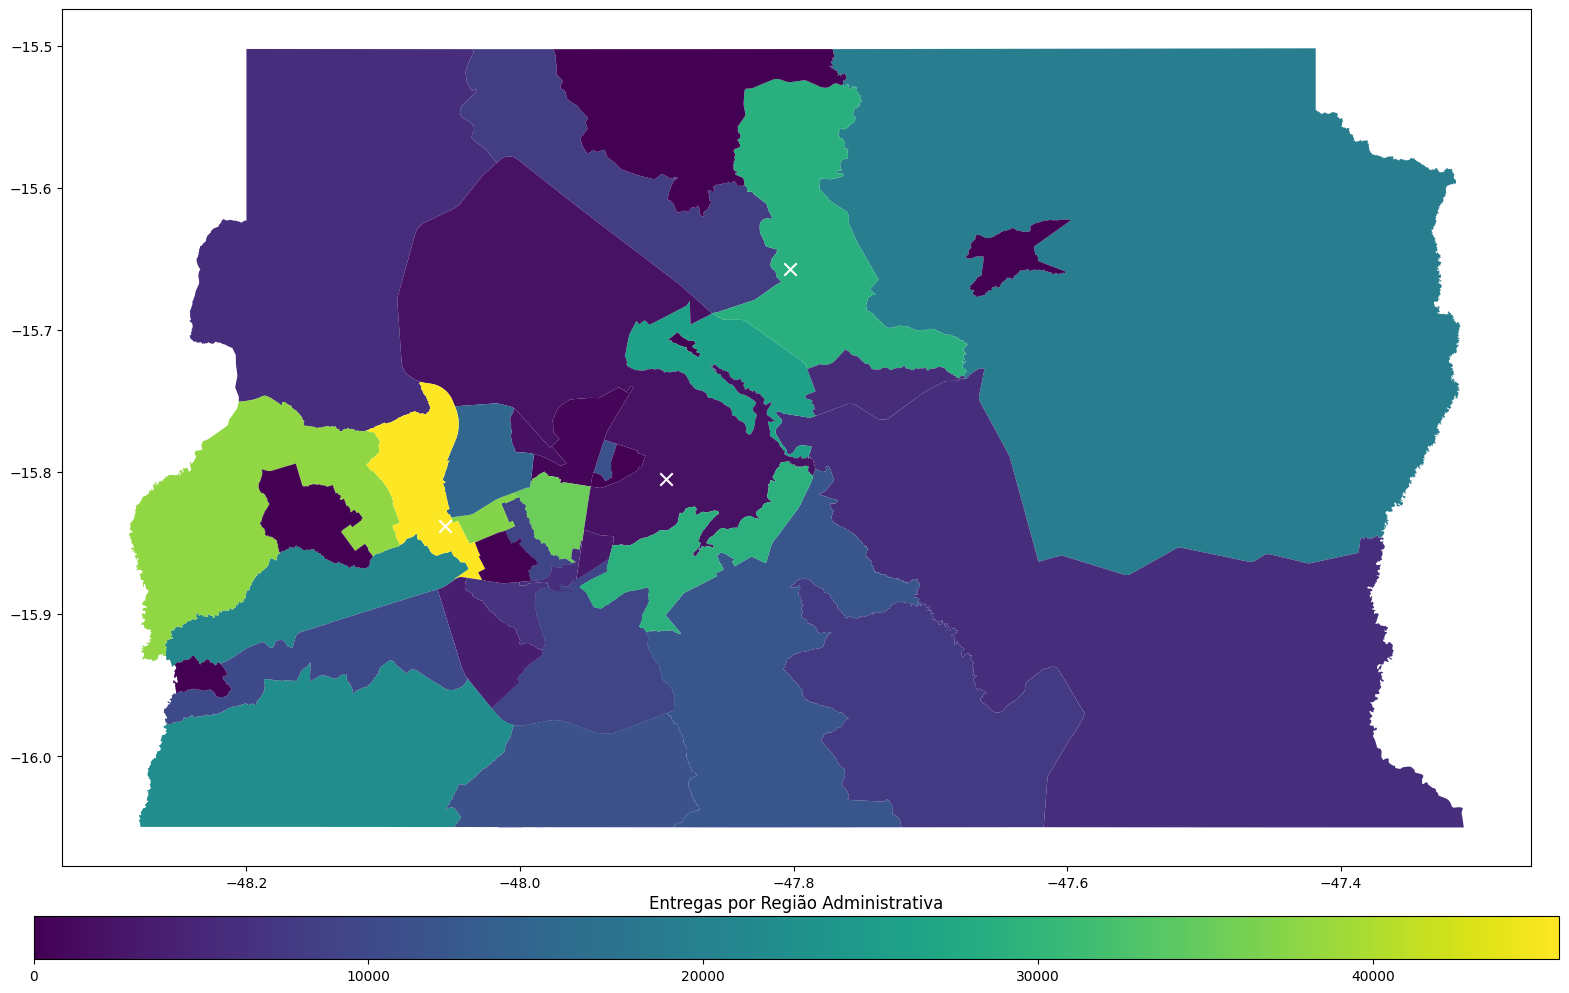

In [69]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
geo_deliveries_map_df.plot(ax=ax, column = 'deliveries')

norm = colors.Normalize(geo_deliveries_map_df["deliveries"].min(), geo_deliveries_map_df["deliveries"].max())

cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)

# plot dos hubs
geo_hub_df.plot(ax=ax, marker='x', color='white', markersize=80)

plt.title("Entregas por Região Administrativa")
plt.show()


O maior número de entregas é realizada na RA que está alocada o df-2, o que é foi uma boa escolha de alocação.